In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline
import seaborn as sns
from tqdm import tqdm_notebook as tqdm

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import RandomForestClassifier

In [3]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')
sample_submission = pd.read_csv('../data/sample_submission.csv')

In [4]:
train.drop(['ID_code'], axis=1, inplace=True)

In [5]:
percent_positive = train[train['target'] == 1].shape[0] / len(train) * 100
print ("Percentage of target == 1: {}%".format(percent_positive))

Percentage of target == 1: 10.049%


### Prepare datasets

In [6]:
X_tr, y_tr = train.drop('target', axis=1), train['target']

### What if `var_68` was the date 

In [6]:
## Train sorted by var_68 (we suppose it to be the date)
train_sorted = train.sort_values('var_68')
X_tr, y_tr = train_sorted.drop('target', axis=1), train_sorted['target']

In [7]:
X_cv, y_cv = X_tr[180000:], y_tr[180000:]
X_tr, y_tr = X_tr[:180000], y_tr[:180000]

### Upsample data 

In [19]:
X_neg, y_neg = X_tr[y_tr == 0], y_tr[y_tr == 0]
X_pos, y_pos = X_tr[y_tr == 1], y_tr[y_tr == 1]

In [20]:
from tqdm import tqdm_notebook as tqdm

In [21]:
X_neg_result = X_neg.copy()
y_neg_result = y_neg.copy()
X_pos_result = X_pos.copy()
y_pos_result = y_pos.copy()

scale = 10 # upsample 10x
feature_prob = 0.2 # 30% probability to shuffle the feature
for i in tqdm(range(scale - 1)):
    X_cur_neg = X_neg.copy()
    for c in X_cur_neg.columns:
        if np.random.rand() < feature_prob:
            cur_feature = X_neg[c].values
            np.random.shuffle(cur_feature)
            X_cur_neg[c] = cur_feature
    
    X_cur_pos = X_pos.copy()
    for c in X_cur_pos.columns:
        if np.random.rand() < feature_prob:
            cur_feature = X_pos[c].values
            np.random.shuffle(cur_feature)
            X_cur_pos[c] = cur_feature

    X_neg_result = pd.concat([X_neg_result, X_cur_neg], ignore_index=True)
    y_neg_result = pd.concat([y_neg_result, y_neg.copy()], ignore_index=True)
    X_pos_result = pd.concat([X_pos_result, X_cur_pos], ignore_index=True)
    y_pos_result = pd.concat([y_pos_result, y_pos.copy()], ignore_index=True)

In [22]:
X_tr = pd.concat([X_neg_result, X_pos_result], ignore_index=True)
y_tr = pd.concat([y_neg_result, y_pos_result], ignore_index=True)

### Consecutive split

In [66]:
ratio = 0.85
neg_split = int(ratio * y_tr[y_tr == 0].shape[0])
pos_split = int(ratio * y_tr[y_tr == 1].shape[0])

In [24]:
x_tr_neg = X_tr[y_tr == 0][:neg_split]
y_tr_neg = y_tr[y_tr == 0][:neg_split]
x_cv_neg = X_tr[y_tr == 0][neg_split:]
y_cv_neg = y_tr[y_tr == 0][neg_split:]

x_tr_pos = X_tr[y_tr == 1][:pos_split]
y_tr_pos = y_tr[y_tr == 1][:pos_split]
x_cv_pos = X_tr[y_tr == 1][pos_split:]
y_cv_pos = y_tr[y_tr == 1][pos_split:]

In [25]:
X_tr = pd.concat([x_tr_neg, x_tr_pos])
y_tr = pd.concat([y_tr_neg, y_tr_pos])
X_cv = pd.concat([x_cv_neg, x_cv_pos])
y_cv = pd.concat([y_cv_neg, y_cv_pos])

### Scale data 

In [17]:
sc = StandardScaler()
X_tr_scaled = sc.fit_transform(X_tr)
X_cv_scaled = sc.transform(X_cv)
X_te_scaled = sc.transform(test[test.columns[1:]])

In [47]:
# scale to (0, 1)
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler(feature_range=(0, 1))
X_tr_minmax = mms.fit_transform(X_tr_scaled)
X_cv_minmax = mms.transform(X_cv_scaled)
X_te_minmax = mms.transform(X_te_scaled)

### Cluster data 

In [9]:
from sklearn.cluster import KMeans

In [10]:
%%time
km = KMeans(n_clusters=2)
km.fit(X_tr)

CPU times: user 50.2 s, sys: 3.39 s, total: 53.6 s
Wall time: 52.6 s


In [24]:
spec_cl.predict(X_te)

array([1, 1, 0, ..., 0, 0, 1], dtype=int32)

### Train data denoiser

In [106]:
from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K

In [167]:
# reparameterization trick
# instead of sampling from Q(z|X), sample epsilon = N(0,I)
# z = z_mean + sqrt(var) * epsilon
def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.
    # Arguments
        args (tensor): mean and log of variance of Q(z|X)
    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [178]:
def create_denoiser(input_shape):
    intermediate_dim = 512
    latent_dim = 16

    inputs = Input(shape=input_shape, name='encoder_input')
    x = Dense(intermediate_dim, activation='relu')(inputs)
    z_mean = Dense(latent_dim, name='z_mean')(x)
    z_log_var = Dense(latent_dim, name='z_log_var')(x)

    # use reparameterization trick to push the sampling out as input
    # note that "output_shape" isn't necessary with the TensorFlow backend
    z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

    # instantiate encoder model
    encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
    encoder.summary()

    # build decoder model
    latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
    x = Dense(intermediate_dim, activation='relu')(latent_inputs)
    outputs = Dense(input_shape[0], activation='sigmoid')(x)

    # instantiate decoder model
    decoder = Model(latent_inputs, outputs, name='decoder')
    decoder.summary()

    # instantiate VAE model
    outputs = decoder(encoder(inputs)[2])
    vae = Model(inputs, outputs, name='vae_mlp')

    # Create loss function
    reconstruction_loss = mse(inputs, outputs)
    reconstruction_loss *= input_shape[0]
    kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    vae_loss = K.mean(reconstruction_loss + kl_loss)
    
    return vae, vae_loss

In [179]:
denoiser, vae_loss = create_denoiser(X_tr.shape[1:])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 200)          0                                            
__________________________________________________________________________________________________
dense_21 (Dense)                (None, 512)          102912      encoder_input[0][0]              
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 16)           8208        dense_21[0][0]                   
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 16)           8208        dense_21[0][0]                   
__________________________________________________________________________________________________
z (Lambda)

In [180]:
denoiser.add_loss(vae_loss)
denoiser.compile(optimizer='adam')
denoiser.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 200)               0         
_________________________________________________________________
encoder (Model)              [(None, 16), (None, 16),  119328    
_________________________________________________________________
decoder (Model)              (None, 200)               111304    
Total params: 230,632
Trainable params: 230,632
Non-trainable params: 0
_________________________________________________________________


#### Train denoiser 

In [181]:
x_train, x_test = train_test_split(X_tr, test_size=0.1)

In [182]:
# Train the autoencoder
batch_size = 128
epochs = 10

denoiser.fit(x_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, None))

Train on 180000 samples, validate on 20000 samples
Epoch 1/10
180000/180000 [==============================] - 15s 82us/step - loss: 4.4866 - val_loss: 4.4619
Epoch 2/10
180000/180000 [==============================] - 10s 56us/step - loss: 4.4538 - val_loss: 4.4597
Epoch 3/10
180000/180000 [==============================] - 10s 55us/step - loss: 4.4532 - val_loss: 4.4595
Epoch 4/10
180000/180000 [==============================] - 11s 63us/step - loss: 4.4530 - val_loss: 4.4593
Epoch 5/10
180000/180000 [==============================] - 11s 61us/step - loss: 4.4529 - val_loss: 4.4592
Epoch 6/10
180000/180000 [==============================] - 14s 76us/step - loss: 4.4529 - val_loss: 4.4592
Epoch 7/10
180000/180000 [==============================] - 12s 66us/step - loss: 4.4528 - val_loss: 4.4593
Epoch 8/10
180000/180000 [==============================] - 10s 58us/step - loss: 4.4528 - val_loss: 4.4593
Epoch 9/10
180000/180000 [==============================] - 12s 67us/step - loss: 4.4

### Train simple Logistic Regression (100 iterations)

In [60]:
def draw_roc_plot(y_true, y_pred):
    title_config = {'fontsize': 20, 'y': 1.05}

    fpr, tpr, thr = roc_curve(y_true, y_pred)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Plot', **title_config)

    return fpr, tpr

In [18]:
lr = LogisticRegression(
    C=0.9,
    penalty='l2',
    multi_class='ovr',
    solver='liblinear',
    random_state=42)

In [19]:
%%time
lr.fit(X_tr_scaled, y_tr)

CPU times: user 3.24 s, sys: 1.2 s, total: 4.44 s
Wall time: 5 s


LogisticRegression(C=0.9, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          n_jobs=None, penalty='l2', random_state=42, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [20]:
lr_preds = lr.predict_proba(X_cv_scaled)[:, 1]

0.8593796377226661

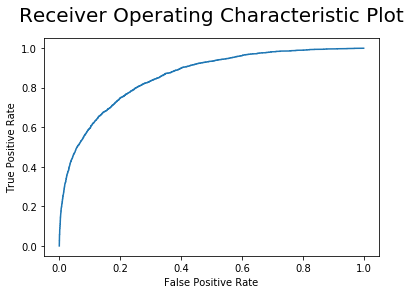

In [21]:
fpr, tpr = draw_roc_plot(y_cv, lr_preds)
auc(fpr, tpr)

### Train Naive Bias classifier 

In [50]:
from sklearn.naive_bayes import GaussianNB
gb = GaussianNB()

In [57]:
x_train, x_cv, y_train, y_cv = train_test_split(X_tr, y_tr, test_size=0.1)

In [58]:
%%time
gb.fit(x_train, y_train)

CPU times: user 787 ms, sys: 314 ms, total: 1.1 s
Wall time: 1.12 s


GaussianNB(priors=None, var_smoothing=1e-09)

Best: 0.8866248124650561

0.8871431065299799

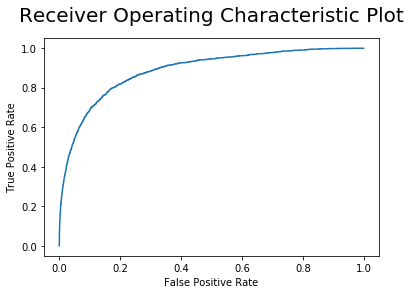

In [61]:
gb_preds = gb.predict_proba(x_cv)
fpr, tpr = draw_roc_plot(y_cv, gb_preds[:, 1])
auc(fpr, tpr)

### Naive bias using K-Fold 

In [23]:
X_tr = X_tr.values # To Numpy

In [25]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import StratifiedKFold

nb_aucs = []
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for k, (tr_idx, cv_idx) in tqdm(enumerate(skf.split(X_tr, y_tr))):
    gb = GaussianNB()
    gb.fit(X_tr[tr_idx], y_tr[tr_idx])
    gb_preds = gb.predict_proba(X_tr[cv_idx])[:, 1]
    cur_auc = roc_auc_score(y_tr[cv_idx], gb_preds)
    print("Fold: {}, AUC: {}".format(k + 1, cur_auc))
    nb_aucs.append(cur_auc)
    
overall = np.mean(nb_aucs)
print("Overall: {}".format(overall))

Fold: 1, AUC: 0.8899826489842915
Fold: 2, AUC: 0.8901050751376619
Fold: 3, AUC: 0.8876304869342002
Fold: 4, AUC: 0.8888108530844776
Fold: 5, AUC: 0.891506285681539

Overall: 0.8896070699644341


Best: 0.8896070699644341

### Train Random Forest classifier 

In [6]:
rf = RandomForestClassifier(n_estimators=25, n_jobs=-1)

In [12]:
%%time
rf.fit(X_tr, y_tr)

CPU times: user 6min 15s, sys: 1.44 s, total: 6min 17s
Wall time: 1min 47s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=25, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [60]:
rf_preds = rf.predict_proba(X_cv)

0.8148753853600184

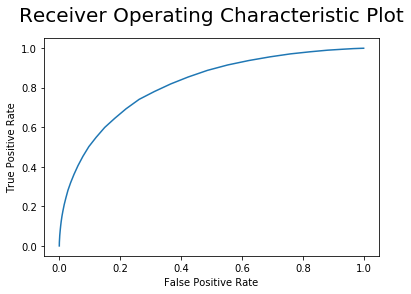

In [61]:
fpr, tpr = draw_roc_plot(y_cv, rf_preds[:, 1])
auc(fpr, tpr)

In [13]:
X_tr.columns

Index(['var_0', 'var_1', 'var_2', 'var_3', 'var_4', 'var_5', 'var_6', 'var_7',
       'var_8', 'var_9',
       ...
       'var_191', 'var_192', 'var_193', 'var_194', 'var_195', 'var_196',
       'var_197', 'var_198', 'var_199', 'sum'],
      dtype='object', length=201)

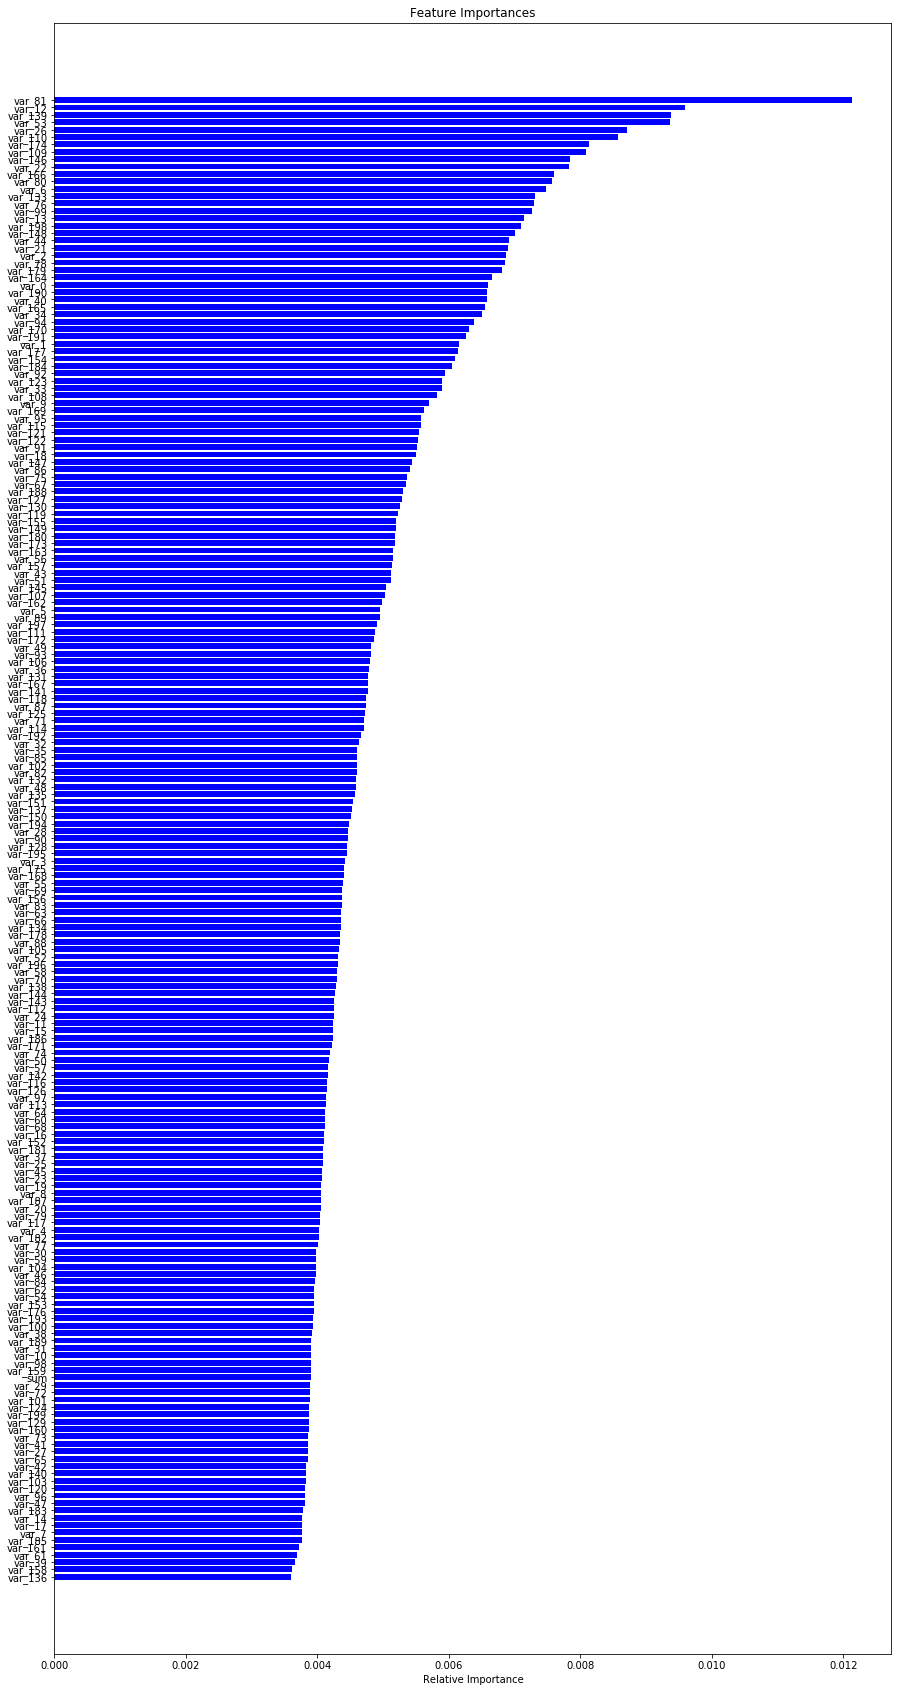

In [14]:
features = X_tr.columns
importances = rf.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(15, 30))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

### Outliers detection 

In [211]:
from sklearn.svm import OneClassSVM

In [212]:
ocsvm = OneClassSVM(gamma='auto', random_state=113)

In [ ]:
ocsvm.fit(X_tr)

/Users/truepk/.pyenv/versions/3.6.7/lib/python3.6/site-packages/sklearn/svm/classes.py:1175: DeprecationWarning: The random_state parameter is deprecated and will be removed in version 0.22.
  " be removed in version 0.22.", DeprecationWarning)


### Submit predictions

In [26]:
preds = gb.predict_proba(test[train.columns[1:]])[:, 1]
submit = sample_submission.copy()
submit['target'] = preds

In [27]:
submit.to_csv('../submits/naive_bias_upsample_9x_positive.csv', index=False)

In [9]:
gaus_best = pd.read_csv('../data/submission_naive_bias.csv')

In [10]:
print (X_tr[y_tr == 0].values.mean())
print (X_tr[y_tr == 0].values.std())

print (X_tr[y_tr == 1].values.mean())
print (X_tr[y_tr == 1].values.std())

6.764947584009617
9.666392455110227
6.789838310030848
9.63430963138328


In [7]:
X_te = test[X_tr.columns]
X_tr_np = X_tr.values
X_te_np = X_te.values

In [27]:
print (X_te[gaus_best.target < 0.5].values.mean())
print (X_te[gaus_best.target < 0.5].values.std())

print (X_te[gaus_best.target >= 0.5].values.mean())
print (X_te[gaus_best.target >= 0.5].values.std())

6.768057250283571
9.66080438056221
6.806302810596364
9.5898768477547


In [19]:
print (X_te_np[current_best < 0.5].mean())
print (X_te_np[current_best < 0.5].std())

print (X_te_np[current_best >= 0.5].mean())
print (X_te_np[current_best >= 0.5].std())

6.768727627370669
9.658990704123639
6.789691417557251
9.634898212527803


In [11]:
current_best = gaus_best.copy().target.values

In [12]:
train_neg_mean = X_tr_np[y_tr == 0].mean()
train_neg_std = X_tr_np[y_tr == 0].std()
train_pos_mean = X_tr_np[y_tr == 1].mean()
train_pos_std = X_tr_np[y_tr == 1].std()
train_stats = np.asarray([train_neg_mean, train_neg_std, train_pos_mean, train_pos_std])

In [16]:
import sys

In [13]:
import cython

%load_ext Cython

In [14]:
%%cython
cimport cython
cimport numpy as np
import numpy as np

cpdef double calc_diff_norm(np.ndarray train_stats,
                    np.ndarray te,
                    np.ndarray preds,
                    double threshold=0.5):
    te_neg = te[preds < threshold]
    te_pos = te[preds >= threshold]
    
    cdef np.ndarray[np.float32_t, ndim=1] test_stats = np.zeros((4, ), dtype=np.float32)
    test_stats[0] = te_neg.mean()
    test_stats[1] = te_neg.std()
    test_stats[2] = te_pos.mean()
    test_stats[3] = te_pos.std()

    return np.linalg.norm(train_stats - test_stats)

In [17]:
threshold = 0.5
best_norm = calc_diff_norm(train_stats, X_te_np, current_best, threshold)

print ('best norm: ', best_norm)

for i in tqdm(range(10000)):
    current = current_best.copy()
    neg_ids = np.where(current < 0.5)[0]
    pos_ids = np.where(current >= 0.5)[0]

    current_neg = np.random.choice(neg_ids, size=100)
    current_pos = np.random.choice(pos_ids, size=100)

    # Swap two random elements from different classes
    current[current_neg], current[current_pos] = current[current_pos], current[current_neg]
    
    current_norm = calc_diff_norm(train_stats, X_te_np, current, threshold)
    
    sys.stdout.write('\rcurrent norm: {}'.format(current_norm))
    sys.stdout.flush()

    if current_norm < best_norm:
        current_best = current.copy()
        best_norm = current_norm
        print (i, end=' ')

best norm:  0.04781450831847213


current norm: 0.008289658784828312 1 2 4 6 7 8 9 11 12 13 14 15 16 18 21 22 23 24 25 26 27 28 29 31 32 33 35 38 39 40 41 42 43 44 45 46 48 49 51 52 55 58 59 60 61 63 69 71 72 75 93 102 105 119 131 132 152 323 

KeyboardInterrupt: 

current norm: 0.0

Exception ignored in: '_cython_magic_532cbc1f9d280d6c5677a59c6e3ece86.calc_diff_norm'
Traceback (most recent call last):
  File "/Users/truepk/.pyenv/versions/3.6.7/lib/python3.6/site-packages/numpy/core/_methods.py", line 58, in _mean
    def _mean(a, axis=None, dtype=None, out=None, keepdims=False):
KeyboardInterrupt


current norm: 0.008369707975712081

KeyboardInterrupt: 

current norm: 0.0

Exception ignored in: '_cython_magic_532cbc1f9d280d6c5677a59c6e3ece86.calc_diff_norm'
Traceback (most recent call last):
  File "/Users/truepk/.pyenv/versions/3.6.7/lib/python3.6/site-packages/numpy/core/_methods.py", line 58, in _mean
    def _mean(a, axis=None, dtype=None, out=None, keepdims=False):
KeyboardInterrupt


KeyboardInterrupt: 

current norm: 0.0

Exception ignored in: '_cython_magic_532cbc1f9d280d6c5677a59c6e3ece86.calc_diff_norm'
Traceback (most recent call last):
  File "/Users/truepk/.pyenv/versions/3.6.7/lib/python3.6/site-packages/numpy/core/_methods.py", line 58, in _mean
    def _mean(a, axis=None, dtype=None, out=None, keepdims=False):
KeyboardInterrupt


KeyboardInterrupt: 

current norm: 0.0

Exception ignored in: '_cython_magic_532cbc1f9d280d6c5677a59c6e3ece86.calc_diff_norm'
Traceback (most recent call last):
  File "/Users/truepk/.pyenv/versions/3.6.7/lib/python3.6/site-packages/numpy/core/_methods.py", line 58, in _mean
    def _mean(a, axis=None, dtype=None, out=None, keepdims=False):
KeyboardInterrupt


KeyboardInterrupt: 

In [76]:
def count_diff(y_true, y_pred, n=100):
    print("Original AUC: {}".format(roc_auc_score(y_true, y_pred)))

    neg_ids = np.where(y_preds < 0.5)[0]
    pos_ids = np.where(y_preds >= 0.5)[0]
    neg_ids_to_swap = np.random.choice(neg_ids, size=n)
    pos_ids_to_swap = np.random.choice(pos_ids, size=n)
    
    preds_new = y_pred.copy()
    preds_new[neg_ids_to_swap] = y_preds[pos_ids_to_swap]
    preds_new[pos_ids_to_swap] = y_preds[neg_ids_to_swap]
    print("{} swaps AUC: {}".format(n, roc_auc_score(y_true, preds_new)))

In [110]:
count_diff(y_true, y_preds, n=10)

Original AUC: 0.8871431065299799
10 swaps AUC: 0.8857402311411203


In [21]:
new_gaus_best = gaus_best.copy()
new_gaus_best.target = current_best
new_gaus_best.to_csv('../submits/naive_bias_with_random_swaps.csv', index=False)